In [1]:
import netCDF4
import pandas
import datetime
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
minCutoffFitLat = 45.
delTimeCutOffNrstPass = 45 # min
mlonDiffOtrEndCutoff = 50.
delLatCutoff = 2.
delCtimeCutoff = 60. #min

In [3]:
fileList = [ "../poes_n15_20130302_proc.nc",\
                "../poes_n18_20130302_proc.nc",\
                "../poes_m01_20130302_proc.nc",\
                "../poes_n19_20130302_proc.nc",\
                "../poes_m01_20130302_proc.nc",\
                "../poes_n16_20130302_proc.nc",\
                "../poes_n17_20130302_proc.nc" ]
poesAllEleDataDF = pandas.DataFrame( columns =  ["timestamp", "date", "aacgm_lat_foot",\
                         "aacgm_lon_foot", "MLT", "log_ele_flux", "sat"] )
poesAllProDataDF = pandas.DataFrame( columns =  ["timestamp", "date", "aacgm_lat_foot",\
                         "aacgm_lon_foot", "MLT", "log_pro_flux", "sat"] )
for f in fileList:
    print "reading file-->", f
    # read variable from the netCDF files
    poesRawData = netCDF4.Dataset(f)
    poesDF = pandas.DataFrame( poesRawData.variables['time'][:], columns=[ "timestamp" ] )
    poesDF['date'] = pandas.to_datetime(poesDF['timestamp'], unit='ms')
    poesDF["alt"] = poesRawData.variables['alt'][:]
    poesDF["aacgm_lat_foot"] = poesRawData.variables['aacgm_lat_foot'][:]

    poesDF["aacgm_lon_foot"] = poesRawData.variables['aacgm_lon_foot'][:]
    poesDF["MLT"] = poesRawData.variables['MLT'][:]
    # round of to 2 decimals
    poesDF['alt'] = [ round( x, 2 ) for x in poesDF['alt']]
    poesDF['aacgm_lat_foot'] = [ round( x, 2 ) for x in poesDF['aacgm_lat_foot']]
    poesDF['aacgm_lon_foot'] = [ round( x, 2 ) for x in poesDF['aacgm_lon_foot']]
    poesDF['MLT'] = [ round( x, 2 ) for x in poesDF['MLT']]
    # Add up the fluxes
    poesDF["ted_ele_total_flux"] = poesRawData.variables['ted_ele_tel0_flux_4'][:] +\
            poesRawData.variables['ted_ele_tel0_flux_8'][:] + \
            poesRawData.variables['ted_ele_tel0_flux_11'][:] + \
            poesRawData.variables['ted_ele_tel0_flux_14'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_4'][:] +\
            poesRawData.variables['ted_ele_tel30_flux_8'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_11'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_14'][:]
    poesDF["ted_pro_total_flux"] = poesRawData.variables['ted_pro_tel0_flux_4'][:] +\
            poesRawData.variables['ted_pro_tel0_flux_8'][:] + \
            poesRawData.variables['ted_pro_tel0_flux_11'][:] + \
            poesRawData.variables['ted_pro_tel0_flux_14'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_4'][:] +\
            poesRawData.variables['ted_pro_tel30_flux_8'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_11'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_14'][:]
    poesDF['log_ele_flux'] = [0. if x <= 0. else round( numpy.log10(x), 2 )\
                 for x in poesDF['ted_ele_total_flux']]
    poesDF['log_pro_flux'] = [0. if x <= 0. else round( numpy.log10(x), 2 )\
                 for x in poesDF['ted_pro_total_flux']]
    # the current satellite number
    poesDF["sat"] = f[-19:-17]
#     seperate out electron and proton flux and discard all zeros
    currPoesEleFluxDF = poesDF[poesDF["log_ele_flux"] > 0.][ ["timestamp",\
                     "date", "aacgm_lat_foot", "aacgm_lon_foot", "MLT",\
                     "log_ele_flux", "sat"] ].reset_index(drop=True)
    currPoesProFluxDF = poesDF[poesDF["log_pro_flux"] > 0.][ ["timestamp",\
                     "date", "aacgm_lat_foot", "aacgm_lon_foot", "MLT",\
                     "log_pro_flux", "sat"] ].reset_index(drop=True)
    
    
    poesAllEleDataDF = poesAllEleDataDF.append( currPoesEleFluxDF )
    poesAllProDataDF = poesAllProDataDF.append( currPoesProFluxDF )
    # now delete all the rows for prev DFs
    # we don't want to duplicate data
    poesDF = poesDF.drop( poesDF.index )
    currPoesEleFluxDF = currPoesEleFluxDF.drop( currPoesEleFluxDF.index )
    currPoesProFluxDF = currPoesProFluxDF.drop( currPoesProFluxDF.index )
# create a date and time columns
poesAllEleDataDF["dateStr"] = poesAllEleDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
poesAllEleDataDF["time"] = poesAllEleDataDF["date"].map(lambda x: x.strftime('%H%M'))
poesAllProDataDF["dateStr"] = poesAllProDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
poesAllProDataDF["time"] = poesAllProDataDF["date"].map(lambda x: x.strftime('%H%M'))

reading file--> ../poes_n15_20130302_proc.nc
reading file--> ../poes_n18_20130302_proc.nc
reading file--> ../poes_m01_20130302_proc.nc
reading file--> ../poes_n19_20130302_proc.nc
reading file--> ../poes_m01_20130302_proc.nc
reading file--> ../poes_n16_20130302_proc.nc
reading file--> ../poes_n17_20130302_proc.nc


In [4]:
timeRange = [ poesAllEleDataDF["date"].min(), poesAllEleDataDF["date"].max() ]
ctime = timeRange[0]
timeInterval=datetime.timedelta(minutes=30)
while ctime <= timeRange[1]:
    ctime += timeInterval
    if abs( ctime - datetime.datetime(2013,3,2,5) ) < datetime.timedelta(minutes=1):
        break
print ctime

2013-03-02 05:00:00.201000


,timestamp,date,aacgm_lat_foot,aacgm_lon_foot,MLT,log_ele_flux,sat,dateStr,time
0,1.362198e+12,2013-03-02 04:20:04.994,-44.64,220.08,13.76,2.89,19,20130302,0420
1,1.362198e+12,2013-03-02 04:20:06.994,-44.53,220.02,13.76,2.78,19,20130302,0420
2,1.362198e+12,2013-03-02 04:20:12.994,-44.20,219.84,13.75,3.03,19,20130302,0420
3,1.362198e+12,2013-03-02 04:20:14.994,-44.09,219.78,13.75,3.03,19,20130302,0420
4,1.362198e+12,2013-03-02 04:20:20.993,-43.77,219.61,13.74,2.55,19,20130302,0420


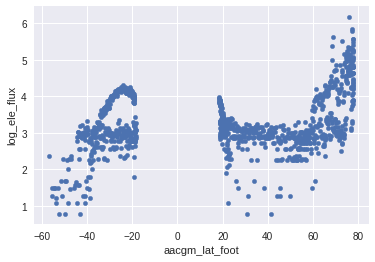

In [13]:
testDF = poesAllEleDataDF[ (poesAllEleDataDF["sat"] == "19") &\
                         (poesAllEleDataDF["date"] >= ctime-datetime.timedelta(minutes=40)) &\
                         (poesAllEleDataDF["date"] <= ctime+datetime.timedelta(minutes=40))].reset_index(drop=True)
testDF.plot( x="aacgm_lat_foot", y="log_ele_flux", kind="scatter" )
testDF.head()

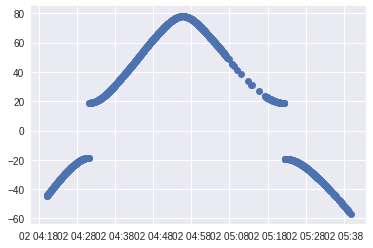

In [14]:
plt.plot_date( testDF["date"], testDF["aacgm_lat_foot"] )